## Capstone Statistics

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

First I will read the data, convert to the correct data types, and recreate the `roi` variable.

In [2]:
loans = pd.read_csv('loans_clean.csv')

In [3]:
pd.options.display.max_rows = 150

In [4]:
dtypes = loans.dtypes
object_vars = list(dtypes[dtypes == 'object'].index)

In [5]:
loans[object_vars] = loans[object_vars].astype('category')

In [6]:
date_vars = ['issue_d', 'earliest_cr_line', 'last_credit_pull_d']
loans.loc[:, date_vars] = loans.loc[:, date_vars].apply(pd.to_datetime, errors='coerce')

In [7]:
loans['roi'] = (loans['total_pymnt'] - loans['funded_amnt']) / loans['funded_amnt']

## Correlation

First I'd like to plot a correlation matrix to see if anything stands out as highly correlated.

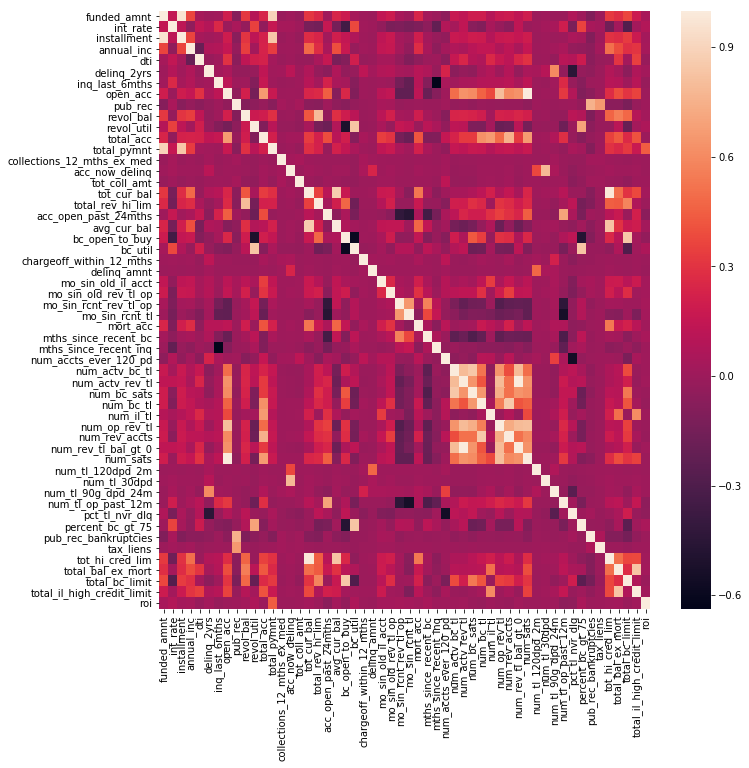

In [9]:
corr = loans.corr()
fig, ax = plt.subplots(figsize=(11,11)) 
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

There are a lot of variables and a lot of information in the graph, so i will just discuss the items that stand out as highly correlated.

The pairwise correlations with the most negative values are are just below -0.6, which is not likely low enough to cause issues with modelling, however, there are several that appear to have a high positive correlation near 1, which could harm the model.

There is a group of higher positively correlated variables in the lower right quadrant, from `num_actv_bc_tl` to `num_sats`. Variables `num_rev_tl_bal_gt_0` (number of revolving accounts with a balance greater than 0) and `num_actv_rev_tl` (number of currently active revolving trades) appear to have the highest correlation.

In [10]:
np.corrcoef(loans.num_rev_tl_bal_gt_0, loans.num_actv_rev_tl)

array([[1.       , 0.9984725],
       [0.9984725, 1.       ]])

`num_rev_tl_bal_gt_0`  and `num_actv_rev_tl` have a correlation coefficient of 0.998, and it will probably make sense to drop one of them.



Variables `tot_hi_cred_lim` (total high credit, or total spending power granted by all credit accounts in use) and `tot_cur_bal` (total current balance of all credit accounts) are highly positively correlated.  These are nearly the same thing.

In [11]:
np.corrcoef(loans.tot_hi_cred_lim, loans.tot_cur_bal)

array([[1.        , 0.98413048],
       [0.98413048, 1.        ]])

`tot_hi_cred_lim` and `tot_cur_bal` have a correlation coefficient of 0.984, and it may help the model to remove one of these.

`num_sats` (Number of satisfactory accounts) and `open_acc` (number of open credit accounts) are highly correlated. It makes sense that these would be correlated when when most or all of the accounts are satisfactory, however, they are not measuring the same thing based on the description. It may be valueable to replace these variables with the a new variable that implies the number or ratio of unsatisfactory accounts.

In [12]:
np.corrcoef(loans.num_sats, loans.open_acc)

array([[1.        , 0.99917058],
       [0.99917058, 1.        ]])

The correlation coefficient is 0.999, meaning these are really describing the same thing and likely one of the variables should be dropped.


Lastly, `funded_amnt` is highly correlated to both `total_pymnt` and `installment`.  This is logical because the higher the loan amount, the higher the installment and total payments will be, but they are also affected by interest rate, and installemnt is additionally affected by term (36 or 60 months).

In [13]:
print(np.corrcoef(loans.funded_amnt, loans.total_pymnt))
print(np.corrcoef(loans.funded_amnt, loans.installment))
print(np.corrcoef(loans.total_pymnt, loans.installment))

[[1.         0.89191117]
 [0.89191117 1.        ]]
[[1.         0.95638073]
 [0.95638073 1.        ]]
[[1.         0.84555917]
 [0.84555917 1.        ]]


Since installment is really a function of funded amount, interest rate, and term, it may not be adding to the model.  Additionally, funded amount and total payments are used to compute the roi variable, which may also add some redundancy.

## Statistical Testing

### Loan Purpose

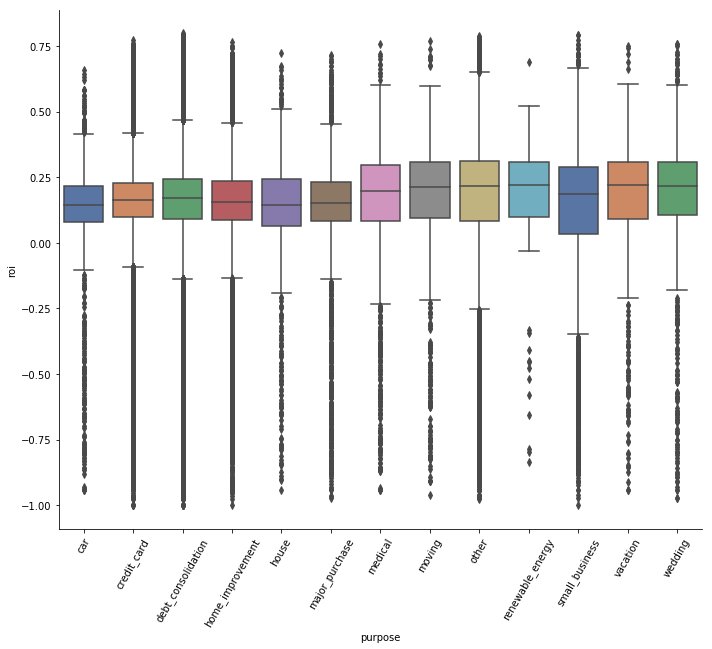

In [14]:
purpose = sns.catplot(x = 'purpose', y='roi', kind = 'box', data=loans, palette="deep", height=8, aspect=10/8)
purpose.set_xticklabels(rotation=60)

There are two major groups of loan purposes. The first 6 variables (car, credit card, debt consolidation, home imporovement, house, and major purchase) have both a lower median roi, and less variance, than the remaining variables. This indicates that the first 6 are less risky with lower rates of default, but also less profitable due to the lower median roi since interest rates tend to be lower for less risky loans.  I will perform a statistical test between the two groups to see if the roi is significantly higher with the second group.

Due to the large amount of data, I will select an alpha of 0.01

Null hypothesis: There is not a difference in mean ROI between group_1 and group 2 borrowers.

Alternate Hypothesis: There is a difference in mean ROI between group_1 and group 2 borrowers.

Test Statistic: Difference of mean ROI.

Significance level: 0.01


First, I will define functions to calculate the test statistic (difference of means), create permutation samples to simulate samples under the null hypothesis, and a function to draw the bootstrap replicates.

In [15]:
def diff_mean(data_a, data_b):
    mean_a = np.mean(data_a)
    mean_b = np.mean(data_b)
    diff = mean_b - mean_a
    return diff

In [16]:
def permutation_sample(data_a, data_b):
    """Generate a permutation sample from two data sets."""
    
    # Concatenate the data sets: data
    data = np.concatenate((data_a, data_b))
    
    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)
    
    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data_a)]
    perm_sample_2 = permuted_data[len(data_b):]
    
    return perm_sample_1, perm_sample_2

In [17]:
def draw_bootstrap_replicates(data_a, data_b, func, size = 1):
    perm_replicates = np.empty(size)
    
    for i in range(size):
        perm_sample_1, perm_sample_2 = permutation_sample(data_a, data_b)
        
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
        
    return perm_replicates

In [18]:
group_1 = ['car', 'credit_card', 'debt_consolidation', 'home_improvement', 'house', 'major_purchase']
group_2 = ['medical', 'moving', 'other', 'renewable_energy', 'small_business', 'vacation', 'wedding']

loans_group_1 = loans.loc[loans['purpose'].isin(group_1)]
loans_group_2 = loans.loc[loans['purpose'].isin(group_2)]

group_1_mean = np.mean(loans_group_1.roi)
group_2_mean = np.mean(loans_group_2.roi)
diff_mean_obs = group_2_mean - group_1_mean

In [19]:
print("Mean ROI for group 1: ", group_1_mean)
print("Mean ROI for group 2: ", group_2_mean)

print("Observed difference of means: ", diff_mean_obs)

Mean ROI for group 1:  0.11996442948784318
Mean ROI for group 2:  0.12636905944602922
Observed difference of means:  0.006404629958186039


In [20]:
bootstrap_replicates = draw_bootstrap_replicates(loans_group_1['roi'], loans_group_2['roi'], diff_mean, 10000)

In [21]:
p_value = np.sum(bootstrap_replicates >= diff_mean_obs)/len(bootstrap_replicates)
p_value

0.0

None of the replicates generated a difference of means as great as the observed data, resulting in a p-value of zero.  Therefore, the null hypothesis can be rejected.

### Debt-to-Income and ROI

In [22]:
loans_sample = loans.sample(frac=0.05)

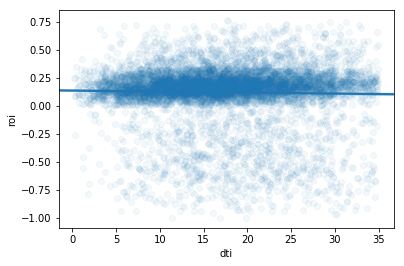

In [23]:
sns.regplot(x = 'dti', y='roi', data=loans_sample, scatter_kws={'alpha':0.05})

`dti` (debt to income ratio) and `roi` do not appear have very much correlation. In the plot, there appears to be just a slightly negative relationship between the two variables. 

In [24]:
np.corrcoef(loans.dti, loans.roi)

array([[ 1.        , -0.01056467],
       [-0.01056467,  1.        ]])

The correlation shows a negative correlation coefficient of -0.0106.  To see if this is significant, I will perform a statistical split the data into a high DTI group (DTI > 25) and a low DTI group (DTI <= 10), and see if the difference in mean DTI between the two groups is significant. Due to the size of the sample, I will select a low alpha level of 0.01.

Null hypothesis: There is not a difference in mean ROI between low DTI borrowers(DTI < 10) and high DTI borrowers (DTI >= 25).

Alternate Hypothesis: There is a difference in mean ROI between low DTI borrowers(DTI < 10) and high DTI borrowers (DTI >= 25).

Test Statistic: Difference of mean ROI.

Significance level: 0.01

In [25]:
high_dti = loans[loans['dti'] <= 10]['roi']
low_dti = loans[loans['dti'] >= 25]['roi']

In [26]:
diff_mean_observed = diff_mean(high_dti, low_dti)
diff_mean_observed

-0.008234808157428372

In [30]:
bootstrap_replicates = draw_bootstrap_replicates(low_dti, high_dti, diff_mean, 10000)

In [31]:
p_value = np.sum(bootstrap_replicates <= diff_mean_observed)/len(bootstrap_replicates)
p_value

0.0001

The p-value is 0.0001, meaning there is very little chance of seeing the observed difference of means (0.008) if the null hypothesis were true.  Therefore, the null hypothesis can be rejected.

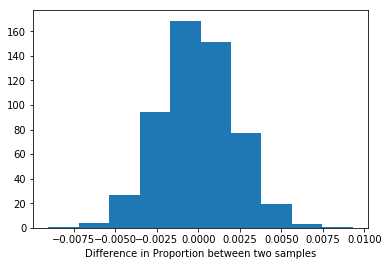

In [32]:
plt.hist(bootstrap_replicates, density = True)
plt.xlabel('Difference in Proportion between two samples')
plt.show()

Visualizing the bootstrap replicates in a histogram shows that a difference in means geater than 0.01 is quite rare if the null hypothesis were true.

Due to the size of the dataset, it can be easy to find statistical significance even with the slightest differences, but further discussion is needed about practical significance. Is it practically significant that loans with low DTI borrowers have a 0.8% higher ROI thab loans with high DTI borrowers?

I will determine the mean loan size, and determine how much more will be repaid on the loans with low-DTI (higher ROI)loans than the high-DTI loans (lower ROI) if the difference in mean ROI is 0.82%.

In [37]:
mean_loan_size = np.mean(loans.funded_amnt)
mean_loan_size

14374.106737555576

In [38]:
abs(mean_loan_size * diff_mean_observed)

118.36801141816878

On an average sized loan of \$14,374, the payback would be \$118 higher based on the mean ROI of the low-DTI group than the mean ROI of the high-DTI group. While not a huge difference, I would still consider this practically significant.